In [22]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

In [2]:
#import sys
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
#from functions import compute_fieldmap

In [2]:
# Select the path to the folder so that it can always address data folder correctly
home_path = "C:/Users/User/msc_project/sus-optimization"

## Cloning repositories </br>
*Should be done only once, important to verify which version of chi to FM is being used*

### Hash where I had the fft bug aka template FM HZ created from: 
*d9f785b082fb145d547ff03ae53f23f1564ccc38*888

In [3]:
# Above method uses the "main" simulation, so we need to load the latest
!git clone https://github.com/shimming-toolbox/susceptibility-to-fieldmap-fft.git
%cd susceptibility-to-fieldmap-fft
!git pull 
!git checkout mb/custom_pad
#!git checkout d9f785b082fb145d547ff03ae53f23f1564ccc38
%pip install .

c:\Users\User\msc_project\sus-optimization\susceptibility-to-fieldmap-fft


Cloning into 'susceptibility-to-fieldmap-fft'...
c:\Users\User\miniconda3\envs\mrsim\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Already up to date.
branch 'mb/custom_pad' set up to track 'origin/mb/custom_pad'.


Switched to a new branch 'mb/custom_pad'
Note: switching to 'd9f785b082fb145d547ff03ae53f23f1564ccc38'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at d9f785b Fix bug


Processing c:\users\user\msc_project\sus-optimization\susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for susceptibility-to-fieldmap-fft: filename=susceptibility_to_fieldmap_fft-0.0.0-py3-none-any.whl size=23545 sha256=c0914fa0f741b67682a41f3aa055a6eba503caa7decedf66ce02e8ef6338f696
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\17\ea\51\22427b7b5d1aced006c3db69245d8a8f88effcb4349a030d61
Successfully built susceptibility-to-fieldmap-fft
  Attempting uninstall: susceptibility-to-fieldmap-fft
    Found existing installation: susceptibility-to-fieldmap-fft 0.0.0
    Uninstalling susceptibility-to-fieldmap-fft-0.0.0:
      Successfully uninstalled susceptibility-to-fieldmap-fft-0.0.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
%cd susceptibility-to-fieldmap-fft

c:\Users\User\msc_project\sus-optimization\susceptibility-to-fieldmap-fft


c:\Users\User\miniconda3\envs\mrsim\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
!git rev-parse HEAD

d9f785b082fb145d547ff03ae53f23f1564ccc38


In [6]:
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\User\msc_project\sus-optimization
README.md
data
evas_code.ipynb
extract_metric.py
internal_air_only.nii.gz
output
requirements.txt
simulation
soothsayer.ipynb
spinal_cord_voxels_only.nii.gz
sus_optimization.ipynb
susceptibility-to-fieldmap-fft
tissue-to-MRproperty


In [28]:
path_to_chi_to_fm_fft = "C:/Users/User/msc_project/susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

In [20]:
#meas_fmap_path = "../data/fm_Hz.nii.gz"
#sim_chi_map_path = "../data/chimap_crop_custom6.nii.gz"
#ROIs_map_path = "../data/mask_crop_gre_fov_body_plus_trachea.nii.gz" # Segmentations

## Importing functions for the optimization process </br>
Importing function to automate command for chi to fm ppm and metric extraction

In [7]:
# We need to reate the custom command that creates the fieldmap
def chi_to_fm_ppm(input_file, output_file):

    #Using a custom command for dB0 simulation

    command = [
    "compute_fieldmap",
    "-i", input_file,
    "-o", output_file,
    "-b", "50",
    "-m", "b0SimISMRM"
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True)

    # We need to return the data from the fieldmap created

    
    # Check for errors
    if result.returncode != 0:
        print("Error occurred:", result.stderr)

    else:
        print("Fieldmap simulated correctly", result.stdout)
        sim_fm_img = nib.load(output_file)
        sim_fm_data = sim_fm_img.get_fdata()
        return sim_fm_data

In [8]:
# Function to automate the subprocess of extractiing measure with SCT through the terminal
from extract_metric import extract_metrics
# Example of calling the function:
#

## Begin! </br>
*That which cannot be measured cannot be controlled; what cannot be controlled cannot be managed; What cannot be managed cannot be optimized* </br>
-Sebastian Rios

## Load variable paths!

In [6]:
# New paths to cropped ISMRM
sim_chi_map_path3 = "data/crop_ISMRM/db0_030_wb_chimap_crop_ISMRM.nii.gz"
segmentations_cropped = "data/crop_ISMRM/db0_030_segmentations_cropped_ISRMRM.nii.gz"
sc_final_mask = "data/crop_ISMRM/sc_seg_c2t7_final_ISMRM.nii.gz"
measured_B0 = "data/crop_ISMRM/B0_cropped_ISMRM.nii.gz"
demodulating_mask_path = "data/crop_ISMRM/sc_seg_dilate2_10.nii.gz"

## Objective function </br>
Minimize the difference of the values on the spinal cord between B0meas and iterativaly changing fieldmaps with different chi values!

### When same subject is used to measure a FM and generate segmentations for simulations </br>
*i.e. all the images are registered to the same space*

In [12]:
def f(x):

    print("Using chi: ",x)
    # load simulated susceptibility map in ppm
    chi_img = nib.load(sim_chi_map_path3)
    chi_data = chi_img.get_fdata()
    
    # load segmentation labels map
    ROIs_img = nib.load(segmentations_cropped)
    ROIs_data = ROIs_img.get_fdata()

    sc_seg_img = nib.load(sc_final_mask)
    sc_seg_data = sc_seg_img.get_fdata()

    demod_mask_img = nib.load(demodulating_mask_path)
    demod_mask_data = demod_mask_img.get_fdata()


    ind_sc = np.where(sc_seg_data == 1)
    # find indicies that have label = 7 or 8, these voxels should correspond to the trachea (t) and lungs (l); ind_tl
    ind_tl = np.where((ROIs_data == 7) | (ROIs_data == 8))
    

    # load simulated field map in Hz
    b0meas_img = nib.load(measured_B0)
    b0meas_data = b0meas_img.get_fdata()

    # assign variable "x" to indicies corresponding to trachea/lungs
    chi_data[ind_tl] = x

    # compute the field distribution in ppm for the chi_data distribution using the compute_bz function from the susceptibility-to-fieldmap-fft package
    #z =  compute_fieldmap.compute_bz(chi_data)
    chi_dist, image_res , affine_matrix = compute_fieldmap.load_sus_dist(sim_chi_map_path3)
    #z = chi_to_fm_ppm(sim_chi_map_path2, output"output/slurp.nii.gz")
    # convert field distribution from ppm to Hz (assuming 3T)
    z = compute_fieldmap.compute_bz(chi_data, image_resolution = image_res , buffer = 50, mode = "b0SimISMRM")
    z = z*3*42.58 # deltaB0 [Hz] = deltaB0 [ppm] * B0 [T] * 1e-6 * 42.58*e6 [Hz/T]

    # Demdoulate Z and b0meas to their own zeros
    # Here we coul check if the voxel is bone or tissue (later on)
    demod_factor_b0meas = np.mean(b0meas_data[demod_mask_data == 1])
    print("Demod factor for B0meas: ", demod_factor_b0meas)
    demod_factor_z = np.mean(z[demod_mask_data == 1])
    print("Demod factor for Simulated: ", demod_factor_z)
    demod_b0_meas = b0meas_data - demod_factor_b0meas
    demod_z = z - demod_factor_z
    difference = np.linalg.norm(demod_b0_meas[ind_sc] - demod_z[ind_sc])
    print("minizing this difference: ", difference)
    return (np.linalg.norm(demod_b0_meas[ind_sc] - demod_z[ind_sc]))

In [ ]:
# extra

### Minimization using average of Verma paper dataset vs trust-worthy segmentation on PAM50 AMU data </br>
*Not using Verma dataset values due to shimming conditions, using db0_030 measured FM*

In [29]:
# Defining average across different subjects - Verma paper dataset:
verma_values_avg = [-183.359, -185.17767, -155.2222625,	-100.69565,	-35.3949375, 25.6912875, 7.387325, -39.7222375, -68.7842375, -61.1716625, -63.731925]

# Using the values from ROMEO measured fieldmap, 2 datasets that differ in the mask used for averaging to zero


# 1: Using a spinal cord mask (small) // Demodulation factor: 162.26 Hz
romeo_sc_avg = []
# 2: Usng a dilated spinal cord mask, includnig bone and bigger ROI // Demodulation factor: 
romeo_sc_dilated = []

# Defining the vertebral levels to be used for optimization:
vertebrae_levels_c2_t7 = [ 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']

In [14]:
# From an already demodulated with 162.26 HZ from a spinal cord mask
# Used also as example for the how to use extract metric automated subprocess
path_to_dmod_b0meas_db0_030 = "data/amu_vs_meas/demoded_fms/demoded_b0meas_img.nii.gz"
path_to_db0_030_sc_mask = 'data/amu_vs_meas/db0_030_only_sc.nii.gz'
path_to_db0_030_vert_levels = "data/amu_vs_meas/db0_030_metric_mask.nii.gz"
path_to_db0_030_metrics = "data/amu_vs_meas/metrics/demoded_b0maes_metrcs.csv"
extract_metrics(path_to_dmod_b0meas_db0_030, path_to_db0_030_sc_mask, path_to_db0_030_vert_levels, path_to_db0_030_metrics, method='wa', vert="2:14")

Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i data/amu_vs_meas/demoded_fms/demoded_b0meas_img.nii.gz -f data/amu_vs_meas/db0_030_only_sc.nii.gz -method wa -vert 2:14 -vertfile data/amu_vs_meas/db0_030_metric_mask.nii.gz -perlevel 1 -o data/amu_vs_meas/metrics/demoded_b0maes_metrcs.csv
--


Load metric image...
Estimation for label: db0_030_only_sc

Done! To view results, type:
start data/amu_vs_meas/metrics/demoded_b0maes_metrcs.csv




In [88]:
avg_zero_dmod_b0meas_csv = pd.read_csv(path_to_db0_030_metrics)
dmod_b0meas_values =  avg_zero_dmod_b0meas_csv['WA()']
dmod_b0meas_values = dmod_b0meas_values[::-1]
# Now this values are from C2 to T7 and will be used for comparison with the simulated from AMU VC subject

In [82]:
# Define the metric folder
path_to_optimization_metrics = "data/amu_vs_meas/metrics/"
path_to_optimization_demod = "data/amu_vs_meas/demoded_fms/"

path_to_sim_vert_file = "data/amu_vs_meas/vertfile_AMU_VC_c2t7.nii.gz"
path_to_amu_demod_mask = "data/amu_vs_meas/demod_masks/c2_t7_sc_mask_AMU_VC_sim.nii.gz"
path_to_amu_chimap = "data/amu_vs_meas/chimap_AMU_VC.nii.gz"
path_to_amu_segs = "data/amu_vs_meas/amu_VC_segmentations.nii.gz"
path_to_amu_sc_mask = "data/amu_vs_meas/spinal_cord_AMU_VC.nii.gz"

# For every chi value we test we are going to create new files for demodulationn and for metrics
# Becaause this is done in a loop we are going to need to create empty list:
chi_tested = []
counter = 0

### f_2 </br>
*Implementation for minimizing the value of chi assuming that chi of lung should be equal to that of trachea*

In [62]:

def f_2(x):
    global counter
    np.append(chi_tested,x)
    print('################')
    value = x.size - 1 # This actually only works when x is of size 1. In f_goat its generalized
    print("Iteration #",counter)
    print("Using chi:",x[value])
    # load simulated susceptibility map in ppm
    # AMU VC for now
    chi_img = nib.load(path_to_amu_chimap)
    chi_data = chi_img.get_fdata()
    
    # load segmentation labels map - AMU chimap
    ROIs_img = nib.load(path_to_amu_segs)
    ROIs_data = ROIs_img.get_fdata()

    #sc_seg_img = nib.load(sc_final_mask)
    #sc_seg_data = sc_seg_img.get_fdata()

    demod_mask_img = nib.load(path_to_amu_demod_mask)
    demod_mask_data = demod_mask_img.get_fdata()

    # All the above can be outside of the loop, save time 

    #ind_sc = np.where(sc_seg_data == 1)
    # find indicies that have label = 4 or 6, these voxels should correspond to the trachea (t) and lungs (l); ind_tl
    ind_tl = np.where((ROIs_data == 4) | (ROIs_data == 6))
    

    # load simulated field map in Hz
    #b0meas_img = nib.load(measured_B0)
    #b0meas_data = b0meas_img.get_fdata()

    # assign variable "x" to indicies corresponding to trachea/lungs
    chi_data[ind_tl] = x

    # compute the field distribution in ppm for the chi_data distribution using the compute_bz function from the susceptibility-to-fieldmap-fft package
    #z =  compute_fieldmap.compute_bz(chi_data)
    chi_dist, image_res , affine_matrix = compute_fieldmap.load_sus_dist(path_to_amu_chimap)
    #z = chi_to_fm_ppm(sim_chi_map_path2, output"output/slurp.nii.gz")

    # convert field distribution from ppm to Hz (assuming 3T)

    z = compute_fieldmap.compute_bz(chi_data, image_resolution = image_res , buffer = 50, mode = "b0SimISMRM")
    z = z*3*42.58 # deltaB0 [Hz] = deltaB0 [ppm] * B0 [T] * 1e-6 * 42.58*e6 [Hz/T]

    chi_val = x[counter]
    chi_name = str(chi_val).replace(".","_").strip("-") # Susceptibility used to test transform to string for the name

    demod_fm_name = f"demod_db0_sim_{chi_name}_fm_Hz.nii.gz"
    path_to_demod_fm = os.path.join(path_to_optimization_demod, demod_fm_name)

    # Demdoulate Z to their own zeros inside the Spinal Cord mask
    # Here we coul check if the voxel is bone or tissue (later on)
    #demod_factor_b0meas = np.mean(b0meas_data[demod_mask_data == 1])
    #print("Demod factor for B0meas: ", demod_factor_b0meas)
    #demod_b0_meas = b0meas_data - demod_factor_b0meas

    demod_factor_z = np.mean(z[demod_mask_data == 1])

    print("Demod factor for Simulated: ", demod_factor_z)
    demod_z = z - demod_factor_z

    demod_fm_Hz = nib.Nifti1Image(demod_z, affine = chi_img.affine)
    nib.save(demod_fm_Hz, path_to_demod_fm)
    print("Filename: ",path_to_demod_fm)

    # Now to extract the metrics:

    metrics_name = f"metrics_db0_sim_{chi_name}_fm_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_optimization_metrics,metrics_name)

    extract_metrics(path_to_demod_fm, path_to_amu_sc_mask, path_to_sim_vert_file, path_to_out_metrics, method='wa', vert="2:14")
    
    avg_zero_dmod_sim_csv = pd.read_csv(path_to_out_metrics)
    dmod_simulated_vals =  avg_zero_dmod_sim_csv['WA()']
    dmod_simulated_vals = dmod_simulated_vals[::-1]

    # Perform the metric extraction

    difference = np.linalg.norm(dmod_b0meas_values-dmod_simulated_vals)
    print(" Minimizing this difference: ", difference)
    
    return difference

In [63]:
min_chi_tl = optimize.fmin(f_2, 0.4)
print("Minimum chi:", min_chi_tl[0])

################
Iteration # 1
Using chi: 0.4
Demod factor for Simulated:  -106.53231631527589
Filename:  data/amu_vs_meas/demoded_fms/demod_db0_sim_0_4_fm_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i data/amu_vs_meas/demoded_fms/demod_db0_sim_0_4_fm_Hz.nii.gz -f data/amu_vs_meas/spinal_cord_AMU_VC.nii.gz -method wa -vert 2:14 -vertfile data/amu_vs_meas/vertfile_AMU_VC_c2t7.nii.gz -perlevel 1 -o data/amu_vs_meas/metrics/metrics_db0_sim_0_4_fm_Hz.csv
--


Load metric image...
Estimation for label: spinal_cord_AMU_VC

Done! To view results, type:
start data/amu_vs_meas/metrics/metrics_db0_sim_0_4_fm_Hz.csv


 Minimizing this difference:  178.47233499290346
################
Iteration # 1
Using chi: 0.42000000000000004
Demod factor for Simulated:  -106.61635395994426
Filename:  data/amu_vs_meas/demoded_fms/demod_db0_sim_0_42000000000000004_fm_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i data

## Plotting </br>
Final results and extra chi values on top!

In [70]:
# Once it runs we can plot it next to the initial measured very ez 
# Just load the csv and its done
#print(min_chi_tl[0]) # FINAL chi value
# We know what the chi of the final metric file is so:
final_chi_name = chi_name = str(min_chi_tl[0]).replace(".","_").strip("-")
final_chi_fm_csv = f"metrics_db0_sim_{final_chi_name}_fm_Hz.csv"
path_to_final_metrics = os.path.join(path_to_optimization_metrics,final_chi_fm_csv)

# Load the csv and extrac values accross c2 through T7

# dmod_b0meas_values = dmod_b0meas_values

final_csv = pd.read_csv(path_to_final_metrics)
final_sim_values =  final_csv['WA()']
final_sim_values = final_sim_values[::-1]


<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_22568\271511628.py:12: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Final comparison $\chi$ = -4.366', fontsize=14)


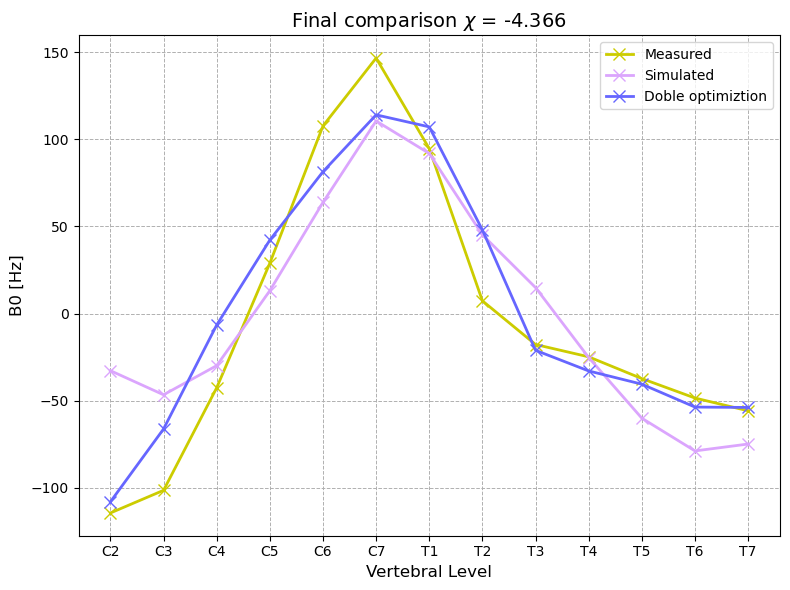

In [127]:
# Final plot of final chi value vs measured
goat_params = [-108.04, -66.25, -6.59, 42.15, 81.38, 114.00, 107.09, 47.94, -21.12, -32.96, -40.55, -53.68, -53.91]
plt.figure(figsize=(8, 6))

# 
plt.plot(vertebrae_levels_c2_t7, dmod_b0meas_values , marker = 'x', color = '#cccc00', linestyle='-', linewidth = 2, markersize = 8, label ='Measured')
plt.plot(vertebrae_levels_c2_t7, final_sim_values , marker = 'x', color = '#DBA5FD', linestyle='-', linewidth = 2, markersize = 8, label ='Simulated')
plt.plot(vertebrae_levels_c2_t7, goat_params , marker = 'x', color = '#6666ff', linestyle='-', linewidth = 2, markersize = 8, label ='Doble optimiztion')


# Add titles and labels
plt.title('Final comparison $\chi$ = -4.366', fontsize=14)
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)

plt.legend()
# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()

<>:49: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:64: SyntaxWarning: invalid escape sequence '\c'
<>:65: SyntaxWarning: invalid escape sequence '\c'
<>:49: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:64: SyntaxWarning: invalid escape sequence '\c'
<>:65: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_22568\1950379016.py:49: SyntaxWarning: invalid escape sequence '\c'
  label=f'$\chi$: {chi_val}', color=gray_colors[color_index % len(colors)])
C:\Users\User\AppData\Local\Temp\ipykernel_22568\1950379016.py:56: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(vertebrae_levels_c2_t7, final_sim_values , marker = '*', color = '#3333ff', linestyle='--', linewidth = 2, markersize = 8, label ='Optimized $\chi$ -4.366')
C:\Users\User\AppData\Local\Temp\ipykernel_22568\1950379016.py:64: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(vert

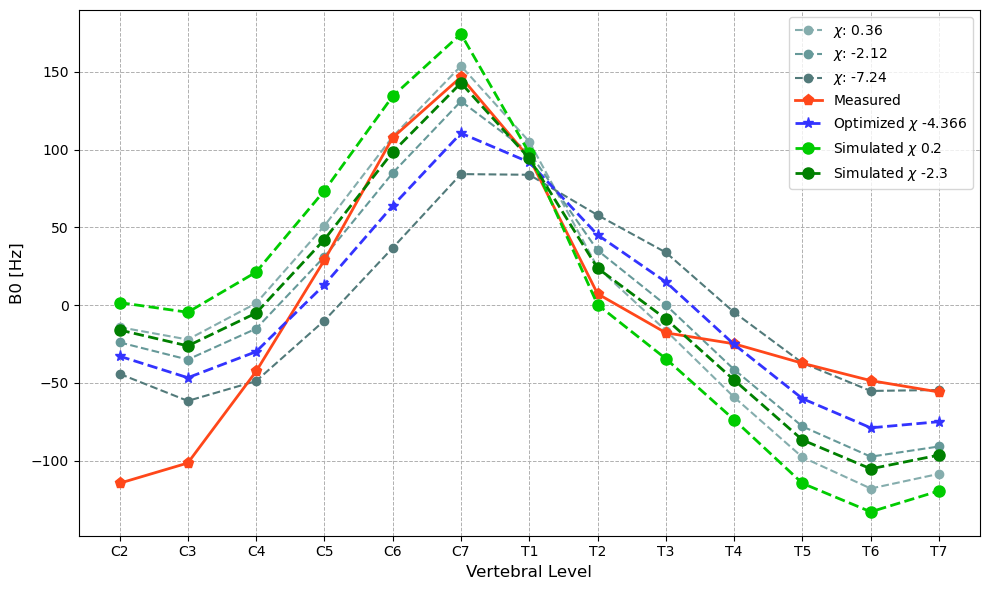

In [135]:
import re


# Some cool extra chi values!
extra_chis_to_plot = ["0_3600000000000001", "2_119999999999995", "7_239999999999984"]

# Vertebral levels and colors, love colors!
vertebrae_levels_c2_t7 = ['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
colors = ['#33C3FF','#DBA5FD','#008000','#4d79ff','996633'] # more to come
gray_colors = ["#85adad","#669999","#527a7a"] # For the extra values
color_index = 0

processed_chis = set() # To avoid repetition of chi values while iterating over filenames

# Initialize 
plt.figure(figsize=(10, 6))

# Loop through each file in the folder
for filename in os.listdir(path_to_optimization_metrics):
    # Check if file is CSV
    if filename.endswith('.csv'):
        # Check for each extra chi value in the filename
        for chi_str in extra_chis_to_plot:
            
            pattern = rf"metrics_db0_sim_{chi_str}_fm_Hz"

            #print(f"Searching for pattern '{pattern}' in filename '{filename}'")  # debugging line
            
            # Adjust for negative values and plot nice chi value instead of np.float .15!
            if re.search(pattern, filename) and chi_str not in processed_chis:
                processed_chis.add(chi_str)
                chi_val = str(chi_str).replace("_",".")
                if float(chi_val) > 1:
                    chi_val = f"-{chi_val}"

                #print(chi_val) # debugging line

                chi_val = round(float(chi_val),3)
                # Load the CSV file
                file_path = os.path.join(path_to_optimization_metrics, filename)
                data = pd.read_csv(file_path)

                # Extract wa column
                column_name = 'WA()' 
                column_data = data[column_name][::-1]  # Reverse the data to have plot from c2 to t7

                # Plot the column data
                plt.plot(vertebrae_levels_c2_t7, column_data, marker='o', linestyle='--',
                         label=f'$\chi$: {chi_val}', color=gray_colors[color_index % len(colors)])
                color_index += 1
                break # Stop after finding the matching chi value for this file

# Add measured data to plot

plt.plot(vertebrae_levels_c2_t7, dmod_b0meas_values , marker = 'p', color = '#ff471a', linestyle='-', linewidth = 2, markersize = 8, label ='Measured')
plt.plot(vertebrae_levels_c2_t7, final_sim_values , marker = '*', color = '#3333ff', linestyle='--', linewidth = 2, markersize = 8, label ='Optimized $\chi$ -4.366')

data_amu_chi_2_3 = [-15.9589, -26.1912, -5.0900, 42.1113, 98.3414, 142.7416, 94.2893, 23.7413, -8.8719, -48.1439, -86.6387, -105.1905, -96.3517]
data_meas = [-114.4866, -101.0895, -43.1777, 28.1947, 108.5242, 146.3648, 94.0083, 9.4665, -17.1480, -24.7593, -37.5776, -48.5010, -55.8265]
vertebrae_levels_c2_t7 = [ 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
data_amu_chi_0_2 = [1.64083, -4.58333, 21.199, 73.5591, 134.231, 174.292, 97.7184, 0.298155, -34.4296, -73.6813, -114.521, -132.822, -119.369]

#plt.plot(vertebrae_levels_c2_t7, data_meas, marker = 'p', color = '#ff471a', linestyle='-', linewidth = 2, markersize = 8, label = "Measured")
plt.plot(vertebrae_levels_c2_t7, data_amu_chi_0_2 , marker = 'o', color = '#00cc00', linestyle='--', linewidth = 2, markersize = 8, label ='Simulated $\chi$ 0.2')
plt.plot(vertebrae_levels_c2_t7, data_amu_chi_2_3 , marker = 'o', color = '#008000', linestyle='--', linewidth = 2, markersize = 8, label ='Simulated $\chi$ -2.3')

# Customize plot appearance
#plt.title('Different chi values')
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()


## Testing using more than 1 input for fmin?

In [123]:
# New outputs
# Define the metric and dmoded folder. This need to change to not overwrite data!
path_to_optimization_metrics_double = "data/amu_vs_meas/test_double_optimize/metrics/"
path_to_optimization_demod_double = "data/amu_vs_meas/test_double_optimize/demoded_fms/"

# This files should always be the same unless something in the pipeline wants to be changed
path_to_sim_vert_file = "data/amu_vs_meas/vertfile_AMU_VC_c2t7.nii.gz"
path_to_amu_demod_mask = "data/amu_vs_meas/demod_masks/c2_t7_sc_mask_AMU_VC_sim.nii.gz"
path_to_amu_chimap = "data/amu_vs_meas/chimap_AMU_VC.nii.gz"
path_to_amu_segs = "data/amu_vs_meas/amu_VC_segmentations.nii.gz"
path_to_amu_sc_mask = "data/amu_vs_meas/spinal_cord_AMU_VC.nii.gz"

# For every chi value we test we are going to create new files for demodulationn and for metrics
# Becaause this is done in a loop we are going to need to create empty list:
chi_tested = []
counter2 = 0

### f_goat </br>
*Chi value of lungs can be different to chi value of trachea*

In [124]:

def f_goat(x):

    global counter2 # This works? 
    counter2 += 1  
    print('################')
    print(f"Iteration #{counter2}")
    print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]}")

    # load simulated susceptibility map in ppm
    # AMU VC for now
    chi_img = nib.load(path_to_amu_chimap)
    chi_data = chi_img.get_fdata()
    
    # load segmentation labels map - AMU chimap
    ROIs_img = nib.load(path_to_amu_segs)
    ROIs_data = ROIs_img.get_fdata()

    #sc_seg_img = nib.load(sc_final_mask)
    #sc_seg_data = sc_seg_img.get_fdata()

    demod_mask_img = nib.load(path_to_amu_demod_mask)
    demod_mask_data = demod_mask_img.get_fdata()

    # All the above can be outside of the loop, save time 

    #ind_sc = np.where(sc_seg_data == 1)
    # find indicies that have label = 4 or 6, these voxels should correspond to the trachea (t) and lungs (l); ind_tl
    ind_trachea = np.where((ROIs_data == 4))
    ind_lung = np.where((ROIs_data == 6))
    

    # load simulated field map in Hz
    #b0meas_img = nib.load(measured_B0)
    #b0meas_data = b0meas_img.get_fdata()

    # assign variable "x" to indicies corresponding to trachea/lungs
    chi_data[ind_trachea] = x[0]
    chi_data[ind_lung] = x[1]
    # compute the field distribution in ppm for the chi_data distribution using the compute_bz function from the susceptibility-to-fieldmap-fft package
    #z =  compute_fieldmap.compute_bz(chi_data)
    chi_dist, image_res , affine_matrix = compute_fieldmap.load_sus_dist(path_to_amu_chimap)
    #z = chi_to_fm_ppm(sim_chi_map_path2, output"output/slurp.nii.gz")

    # convert field distribution from ppm to Hz (assuming 3T)

    z = compute_fieldmap.compute_bz(chi_data, image_resolution = image_res , buffer = 50, mode = "b0SimISMRM")
    z = z*3*42.58 # deltaB0 [Hz] = deltaB0 [ppm] * B0 [T] * 1e-6 * 42.58*e6 [Hz/T]

    chi1 = x[0]
    chi2 = x[1]
    #chi_name = str(chi_val).replace(".","_").strip("-") # Susceptibility used to test transform to string for the name

    chi1_name = str(chi1).replace(".","_").strip("-")
    chi2_name = str(chi2).replace(".","_").strip("-")

    demod_fm_name = f"demod_db0_sim_t_{chi1_name}_l_{chi2_name}_fm_Hz.nii.gz"
    path_to_demod_fm = os.path.join(path_to_optimization_demod_double, demod_fm_name)

    # Demdoulate Z to their own zeros inside the Spinal Cord mask
    # Here we coul check if the voxel is bone or tissue (later on)
    #demod_factor_b0meas = np.mean(b0meas_data[demod_mask_data == 1])
    #print("Demod factor for B0meas: ", demod_factor_b0meas)
    #demod_b0_meas = b0meas_data - demod_factor_b0meas

    demod_factor_z = np.mean(z[demod_mask_data == 1])

    print("Demod factor for Simulated: ", demod_factor_z)
    demod_z = z - demod_factor_z

    demod_fm_Hz = nib.Nifti1Image(demod_z, affine = chi_img.affine)
    nib.save(demod_fm_Hz, path_to_demod_fm)
    print("Filename: ",path_to_demod_fm)

    # Now to extract the metrics:

    metrics_name = f"metrics_db0_sim_t_{chi1_name}_l_{chi2_name}_fm_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_optimization_metrics_double,metrics_name)

    extract_metrics(path_to_demod_fm, path_to_amu_sc_mask, path_to_sim_vert_file, path_to_out_metrics, method='wa', vert="2:14")
    
    avg_zero_dmod_sim_csv = pd.read_csv(path_to_out_metrics)
    dmod_simulated_vals =  avg_zero_dmod_sim_csv['WA()']
    dmod_simulated_vals = dmod_simulated_vals[::-1]

    # Perform the metric extraction

    difference = np.linalg.norm(dmod_b0meas_values-dmod_simulated_vals)
    print(" Minimizing this difference: ", difference)
    
    return difference

In [125]:
goated_params = optimize.fmin(f_goat, [0.4,-2.65])
print("Minimum chi trachea: ", goated_params[0], "& chi lungs:", goated_params[1])

################
Iteration #1
Current values of variables: x[0] = 0.4, x[1] = -2.65
Demod factor for Simulated:  -93.75755052013716
Filename:  data/amu_vs_meas/test_double_optimize/demoded_fms/demod_db0_sim_t_0_4_l_2_65_fm_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i data/amu_vs_meas/test_double_optimize/demoded_fms/demod_db0_sim_t_0_4_l_2_65_fm_Hz.nii.gz -f data/amu_vs_meas/spinal_cord_AMU_VC.nii.gz -method wa -vert 2:14 -vertfile data/amu_vs_meas/vertfile_AMU_VC_c2t7.nii.gz -perlevel 1 -o data/amu_vs_meas/test_double_optimize/metrics/metrics_db0_sim_t_0_4_l_2_65_fm_Hz.csv
--


Load metric image...
Estimation for label: spinal_cord_AMU_VC

Done! To view results, type:
start data/amu_vs_meas/test_double_optimize/metrics/metrics_db0_sim_t_0_4_l_2_65_fm_Hz.csv


 Minimizing this difference:  137.94889982496622
################
Iteration #2
Current values of variables: x[0] = 0.42000000000000004, x[1] = -2.65
Demod factor for Simulated:  -

# Extras


In [61]:
dbounds = [(-5,0.4)]
min_chi_tl = optimize.minimize(f_2, -4.2, bounds=bounds)
print("Minimum chi:", min_chi_tl.x[0])
print("Optimization success:", min_chi_tl.success)  # Check if the optimization was successful
print("Message:", min_chi_tl.message) 

################
Iteration # 1
Using chi: -4.2
Demod factor for Simulated:  -87.20365804155139
Filename:  data/amu_vs_meas/demoded_fms/demod_db0_sim_4_2_fm_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i data/amu_vs_meas/demoded_fms/demod_db0_sim_4_2_fm_Hz.nii.gz -f data/amu_vs_meas/spinal_cord_AMU_VC.nii.gz -method wa -vert 2:14 -vertfile data/amu_vs_meas/vertfile_AMU_VC_c2t7.nii.gz -perlevel 1 -o data/amu_vs_meas/metrics/metrics_db0_sim_4_2_fm_Hz.csv
--


Load metric image...
Estimation for label: spinal_cord_AMU_VC

Done! To view results, type:
start data/amu_vs_meas/metrics/metrics_db0_sim_4_2_fm_Hz.csv




ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [10]:
print("Minimum chi:", min_chi_tl.x[0])

Minimum chi: [-0.20583366]


In [16]:
bounds = [(-9.05,0)]
min_chi_tl = optimize.minimize(f, 0.35, bounds=bounds)
print("Minimum chi:", min_chi_tl.x[0])
print("Optimization success:", min_chi_tl.success)  # Check if the optimization was successful
print("Message:", min_chi_tl.message) 

Using chi:  [0.]
Demod factor for B0meas:  132.99112910454772
Demod factor for Simulated:  -298.65534837507926
Using chi:  [-1.e-08]
Demod factor for B0meas:  132.99112910454772
Demod factor for Simulated:  -298.6553483744052
Minimum chi: 0.0
Optimization success: True
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


# Testing everything
For the new chimaps, there is no spinal cord added but we have the spina cord segmentation

In [19]:
    # load simulated susceptibility map in ppm
chi_img = nib.load(sim_chi_map_path3)
chi_data = chi_img.get_fdata()
    
    # load segmentation labels map
ROIs_img = nib.load(segmentations_cropped)
ROIs_data = ROIs_img.get_fdata()

sc_seg_img = nib.load(sc_final_mask)
sc_seg_data = sc_seg_img.get_fdata()

demod_mask_img = nib.load(demodulating_mask_path)
demod_mask_data = demod_mask_img.get_fdata()


ind_sc = np.where(sc_seg_data == 1)
    # find indicies that have label = 7 or 8, these voxels should correspond to the trachea (t) and lungs (l); ind_tl
ind_tl = np.where((ROIs_data == 7) | (ROIs_data == 8))
    

    # load simulated field map in Hz
b0meas_img = nib.load(measured_B0)
b0meas_data = b0meas_img.get_fdata()

    # assign variable "x" to indicies corresponding to trachea/lungs
chi_data[ind_tl] = -4.2 # x in the loop above

    # compute the field distribution in ppm for the chi_data distribution using the compute_bz function from the susceptibility-to-fieldmap-fft package
    #z =  compute_fieldmap.compute_bz(chi_data)
chi_dist, image_res , affine_matrix = compute_fieldmap.load_sus_dist(sim_chi_map_path3)
    #z = chi_to_fm_ppm(sim_chi_map_path2, output"output/slurp.nii.gz")
    # convert field distribution from ppm to Hz (assuming 3T)
z = compute_fieldmap.compute_bz(chi_data, image_resolution = image_res , buffer = 50, mode = "b0SimISMRM")
z = z*3*42.58 # deltaB0 [Hz] = deltaB0 [ppm] * B0 [T] * 1e-6 * 42.58*e6 [Hz/T]

demod_factor_z = np.mean(z[demod_mask_data == 1])
print("Demod factor for Simulated: ", demod_factor_z)
demod_z = z - demod_factor_z


Demod factor for Simulated:  nan


(191, 285, 843)

In [15]:
# Quickly check if the ind_tl is actually taking the lungs or not
ind_tl = np.where((ROIs_data == 7) | (ROIs_data == 8))

only_internal_air = np.zeros(np.shape(ROIs_data))
only_internal_air[ind_tl] = 1

only_air_img = nib.Nifti1Image(only_internal_air, affine=ROIs_img.affine)
nib.save(only_air_img, "internal_air_only.nii.gz")

### Using subprocess to test if we are using the correct version of compute_bz

In [8]:
# For sure that compute_bz is not returning the same even using the same chi value
# Lets test calling with the custom function
def chi_to_fm_ppm(input_file, output_file):

    #Using a custom command for dB0 simulation

    command = [
    "compute_fieldmap",
    "-i", input_file,
    "-o", output_file,
    "-b", "50",
    "-m", "b0SimISMRM"
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True)
    
    # Check for errors
    if result.returncode != 0:
        print("Error occurred:", result.stderr)
    else:
        print("FM created successfully:", result.stdout)

In [9]:
chi_to_fm_ppm(sim_chi_map_path3,"output/please_please_please.nii.gz")

FM created successfully: Start
Susceptibility distribution loaded
Fieldmap simulated
Saving to NIfTI format
End. Runtime: 20.40 seconds



In [36]:
z_img_demod = nib.Nifti1Image(demod_z, affine = chi_img.affine)
nib.save(z_img_demod, "output/z_demoded_img.nii.gz")

In [33]:
sc_voxels_only = np.zeros_like(sc_seg_data)

# Fill the spinal cord voxels
sc_voxels_only[ind_sc] = demod_z[ind_sc]

# Save the new mask as a NIfTI file for visual inspection
masked_img = nib.Nifti1Image(sc_voxels_only, affine=sc_seg_img.affine)
nib.save(masked_img, "spinal_cord_voxels_only.nii.gz")


In [ ]:
bounds = [(-5,0.4)]
min_chi_tl = optimize.minimize(f, -4.2, bounds=bounds)
print("Minimum chi:", min_chi_tl.x[0])
print("Optimization success:", min_chi_tl.success)  # Check if the optimization was successful
print("Message:", min_chi_tl.message) 

Using chi:  [-4.2]
Demod factor for B0meas:  132.99112910454772
Demod factor for Simulated:  -298.37221739257666
Using chi:  [-4.19999999]
Demod factor for B0meas:  132.99112910454772
Demod factor for Simulated:  -298.37221739325076
Using chi:  [0.4]
Demod factor for B0meas:  132.99112910454772
Demod factor for Simulated:  -298.6823132305558
Using chi:  [0.39999999]
Demod factor for B0meas:  132.99112910454772
Demod factor for Simulated:  -298.6823132298815
Minimum chi: 0.4
Optimization success: True
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


In [26]:
# What I want to do is mask this voxels out and see if they are literally the same 
masked_b0meas = np.zeros(np.shape(b0meas_data))
masked_chi_dist = np.zeros(np.shape(chi_data))

masked_b0meas = b0meas_data[sc_seg_data == 1]

masked_b0_img = nib.Nifti1Image(masked_b0meas, affine=b0meas_img.affine)
nib.save(masked_b0_img, "output/masked/masked_B0meas.nii.gz")

masked_chimap = chi_data[ind_sc]

masked_chimap_img = nib.Nifti1Image(masked_chimap, affine=chi_img.affine)
nib.save(masked_chimap_img, "output/masked/mask_chimap.nii.gz")

In [23]:
np.shape(b0meas_data)

(191, 285, 843)

In [ ]:
z_img = nib.nifti1Image(z, affine = chi_img.affine)
nib.save(z_img, "output/z_image_chi.nii.gz")